In [1]:
# Load our data into a dataframe
import pandas
events = pandas.read_csv('connected_cars.csv')

In [2]:
events.describe()

,x,y
count,128561.000000,128561.000000
mean,1.447089,-0.189747
std,6.783942,3.827694
min,-0.421590,-37.440000
25%,0.002490,-0.198850
50%,0.213070,-0.039020
75%,0.279080,0.007720
max,122.160000,1256.560000


In [3]:
events.head()

,driver_id,x,y,date,time
0,A,-0.26290,0.33689,2014/04/08,20:44:47
1,A,-0.24492,0.30324,2014/03/24,21:13:37
2,A,-0.27369,0.34901,2014/04/02,21:47:18
3,A,-0.24701,0.27861,2014/03/30,20:07:30
4,A,-0.26202,0.30296,2014/03/23,21:48:32


In [4]:
events.tail()

,driver_id,x,y,date,time
128558,G,-0.00195,0.00838,2014/02/02,04:24:54
128559,G,-0.27914,0.36023,2014/02/01,22:23:18
128560,G,-0.02621,0.03884,2014/03/22,22:14:11
128561,G,0.00184,0.00323,2014/01/16,17:31:15
128562,G,0.00253,0.00272,2014/01/31,20:31:03


In [5]:
from datetime import datetime, timedelta

def parse_datetime(date_str, time_str):
    '''
    Date should be a string in format YYYY/MM/DD, and time should 
    be a string in format HH:MM:SS (24 hour time).  Together, they
    should specify a time in UTC.
    
    Returns a datetime object relative to PDT.
    
    If the format of either date_str or time_str is invalid, returns null.
    '''
    try:
        utc_date = datetime.strptime(date_str, '%Y/%m/%d').date()
        utc_time = datetime.strptime(time_str, '%H:%M:%S').time()
    except (ValueError, TypeError):
        return None
    
    utc_dt = datetime.combine(utc_date, utc_time)
    pdt_dt = utc_dt - timedelta(hours=7) # UTC is 7 hours ahead of PDT
    return pdt_dt

In [6]:
# Update the events dataframe to have parsed dates and times relative to PST
parsed_datetimes = [parse_datetime(date, time) for date, time in zip(events['date'], events['time'])]
events['date'] = [dt and dt.date() for dt in parsed_datetimes]
events['time'] = [dt and dt.time() for dt in parsed_datetimes]

In [7]:
# Remove rows of the dataframe with invalid dates or times
events = events[events['date'].apply(lambda d: d is not None)]
events = events[events['time'].apply(lambda d: d is not None)]
events.count()

driver_id    128520
x            128520
y            128520
date         128520
time         128520
dtype: int64

In [8]:
# Collect statistics on the sampling frequency of our data

from itertools import islice
from datetime import datetime

def get_sampling_intervals(person_id):
    # Calculate sampling intervals per person and date
    person_events = events[events['driver_id'] == person_id]
    
    sampling_intervals = []
    for date, group in person_events.groupby(['date']):
        times = sorted(group['time'])
        for time1, time2 in zip(times, islice(times, 1, None)):
            interval = datetime.combine(date, time2) - datetime.combine(date, time1)
            # Record the interval in minutes
            sampling_intervals.append(interval.seconds / 60.)
            
    return sampling_intervals

In [9]:
# Find the unique people in our dataset
import numpy
people = numpy.unique(events['driver_id'])
len(people)

7

In [10]:
all_sampling_intervals = [i for p in people for i in get_sampling_intervals(p)]

Populating the interactive namespace from numpy and matplotlib


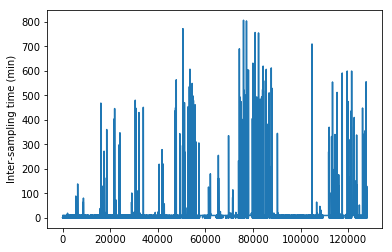

In [11]:
# Make plots appear inline
%pylab inline --no-import-all 

# Importing this makes plots more visually pleasing
import seaborn

# Plot the sampling frequency
plt.plot(all_sampling_intervals)
plt.ylabel('Inter-sampling time (min)')
plt.show()

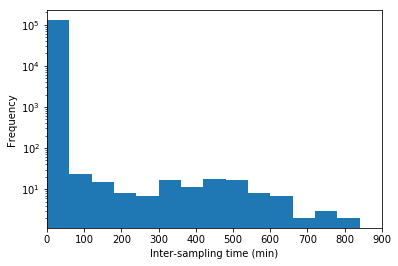

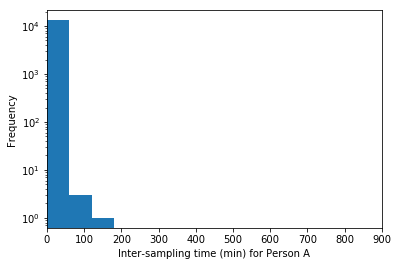

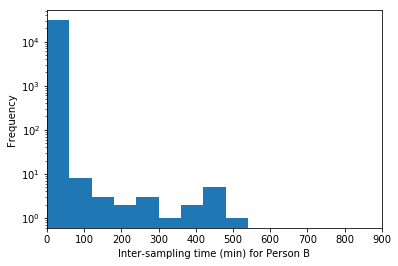

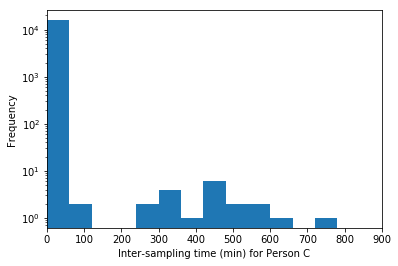

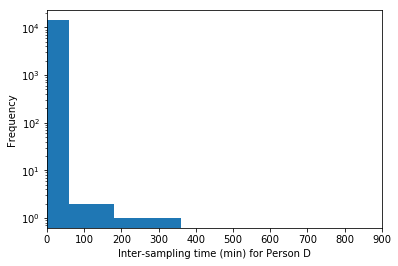

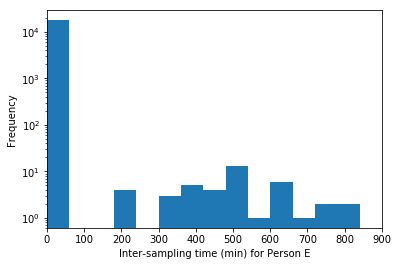

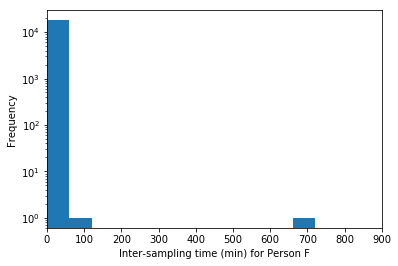

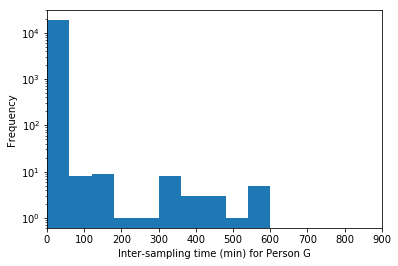

In [12]:
def plot_sampling_intervals(sampling_intervals, person_id=None):
    # Range determines the range used to divide the bins, and xlim determines
    # the range of the axis labels
    plt.hist(sampling_intervals, bins=15, log=True, range=(0,900))
    plt.xlim((0, 900))
    person_message = ' for Person {}'.format(person_id) if person_id is not None else ''
    plt.xlabel('Inter-sampling time (min){}'.format(person_message))
    plt.ylabel('Frequency')
    plt.show()
    
# Plot the sampling frequency for everyone
plot_sampling_intervals(all_sampling_intervals)

# Plot the sampling frequency for each person separately
for person_id in sorted(set(events['driver_id'].values)):
    sampling_intervals = get_sampling_intervals(person_id)
    plot_sampling_intervals(sampling_intervals, person_id)

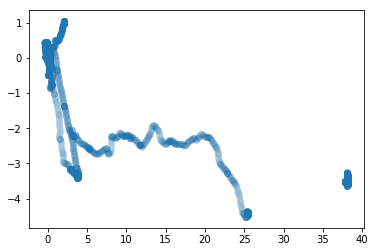

In [13]:
plt.scatter(events['x'], events['y'], marker='o', alpha=0.03);

In [14]:
# Restrict events to the region -1 to 1 in both x and y dimensions
restricted_region = events[events['x'] >= -1]
restricted_region = restricted_region[restricted_region['x'] <= 1]
restricted_region = restricted_region[restricted_region['y'] >= -1]
restricted_region = restricted_region[restricted_region['y'] <= 1]

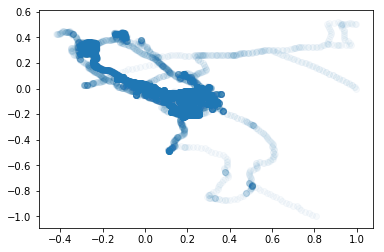

In [15]:
# Make a scatterplot of all locations
plt.scatter(restricted_region['x'], restricted_region['y'], marker='o', alpha=0.03)

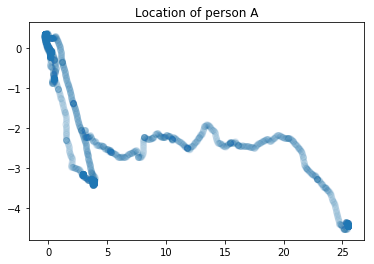

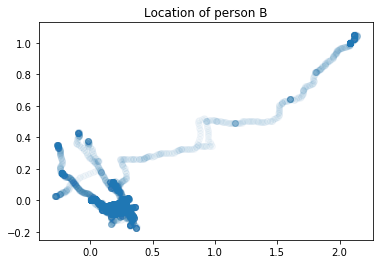

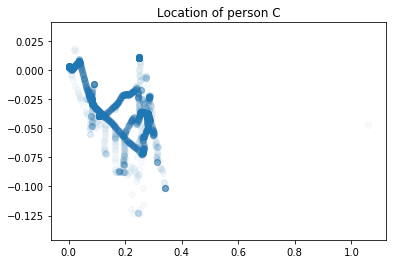

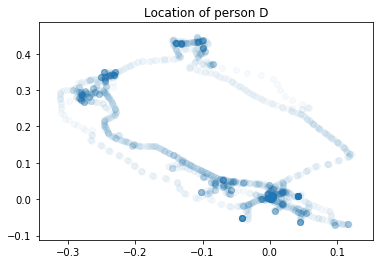

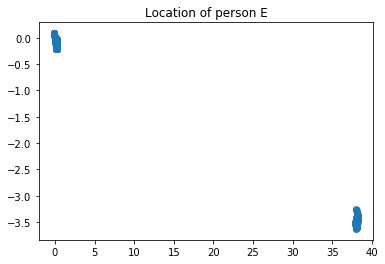

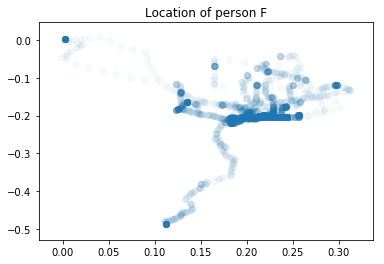

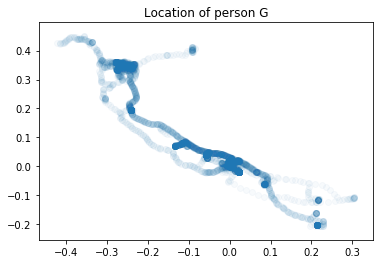

In [16]:
# Plot the location of each person on a separate plot
plt.clf()
for person in people:
    person_events = events[events['driver_id'] == person]
    plt.scatter(person_events['x'], person_events['y'], marker='o', alpha=0.03)
    plt.title('Location of person {}'.format(person))
    plt.show()

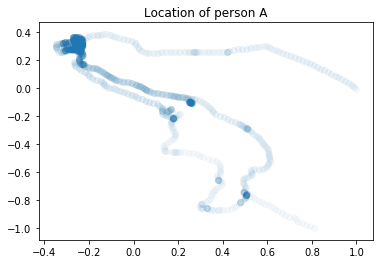

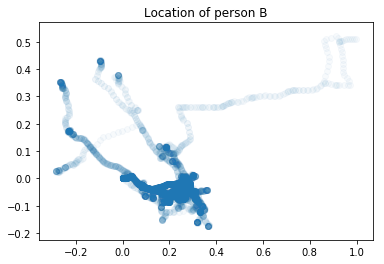

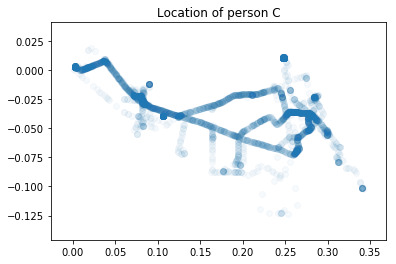

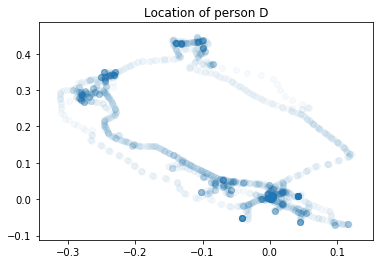

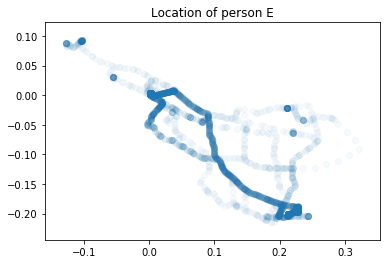

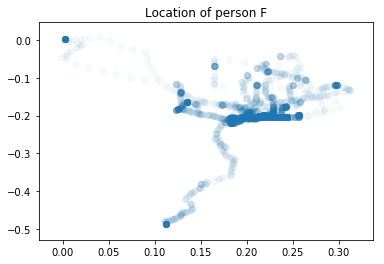

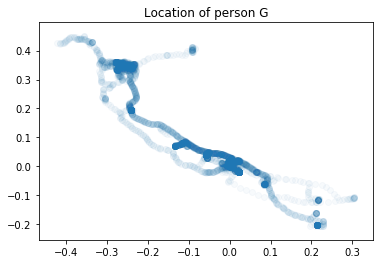

In [17]:
# Plot the location of each person within the restricted region
plt.clf()
for person in people:
    person_events = restricted_region[restricted_region['driver_id'] == person]
    plt.scatter(person_events['x'], person_events['y'], marker='o', alpha=0.03)
    plt.title('Location of person {}'.format(person))
    plt.show()

In [18]:
# Calculate the Euclidean distance between two points
import math
def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)
distance_metric = euclidean_distance

In [19]:
# Calculate each person's distance from the origin at 4 pm, 5 pm, 6 pm, and 7 pm every day
# The distances will be our feature vectors, X
# The people will be our classes, y

# Then we can try to predict which of our two selected people a day's worth
# of data belongs to.

from bisect import bisect_left
from datetime import time

origin_x = 0
origin_y = 0

times_to_measure = [time(16, 0, 0), time(17, 0, 0), time(18, 0, 0), time(19, 0, 0)] #, time(23, 59, 0)]

def calculate_points(events):
    X = []
    y = []
    
    # Go through each person and day in the data
    for (person_id, date), event_group in events.groupby(['driver_id', 'date']):
        event_group = event_group.sort('time')
        distances = []
        
        for time in times_to_measure:
            # Find the location at each time by finding the earliest 
            # reported location at or after that time
            i = bisect_left(event_group['time'].values, time)
            
            # If no location was reported at or after the given time, just use
            # the latest reported location
            if i == event_group['time'].count():
                i -= 1
                
            event = event_group.iloc[i]
            dist = distance_metric(event['x'], event['y'], origin_x, origin_y)
            distances.append(dist)
            
        X.append(distances)
        y.append(person_id)
        
    return X, y

In [20]:
for person, event_group in events.groupby(['driver_id']):
    print('Person {}: num events = {}'.format(person, len(numpy.unique(event_group['date']))))

Person A: num events = 47
Person B: num events = 123
Person C: num events = 83
Person D: num events = 84
Person E: num events = 92
Person F: num events = 96
Person G: num events = 103


In [21]:
# Choose two people for our classification problem
person1 = 'B'
person2 = 'F'

classification_events = events[events['driver_id'].apply(lambda p: p == person1 or p == person2)]

In [22]:
X, y = calculate_points(classification_events)

D:\Anaconda\envs\aind\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [23]:
# Make our results reproducible
from numpy import random
random.seed(1234)

In [26]:
# Select a training set and a test set

def split_train_test(X, y, train_percent=0.6):
    split_index = int(len(X) * train_percent)
    
    # Combine features and labels into a single list so we can shuffle together
    points = list(zip(X, y))
    random.shuffle(points)
    training_points = points[:split_index]
    test_points = points[split_index:]
    
    
    # Now that our points have been randomly ordered, separate the features from the labels again
    # Also put them in numpy arrays.
    X_train = numpy.array([X_point for (X_point, y_point) in training_points])
    y_train = numpy.array([y_point for (X_point, y_point) in training_points])
    
    X_test = numpy.array([X_point for (X_point, y_point) in test_points])
    y_test = numpy.array([y_point for (X_point, y_point) in test_points])
    
    return X_train, y_train, X_test, y_test

In [27]:
X_train, y_train, X_test, y_test = split_train_test(X, y)

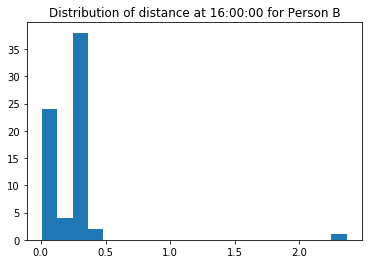

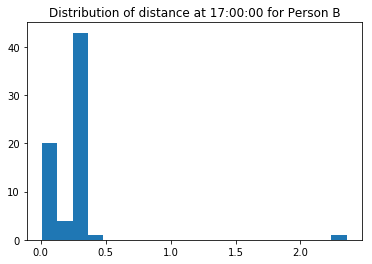

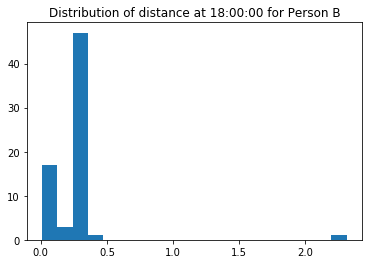

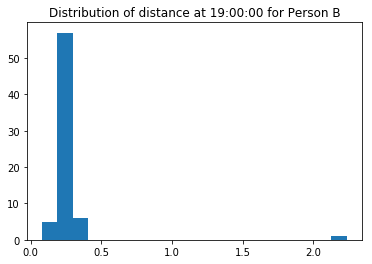

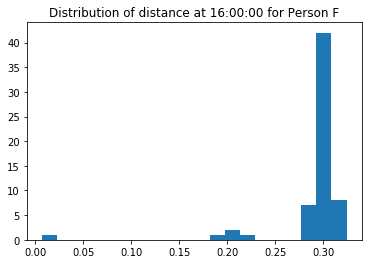

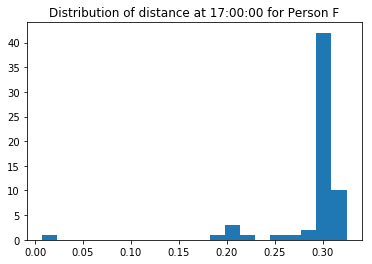

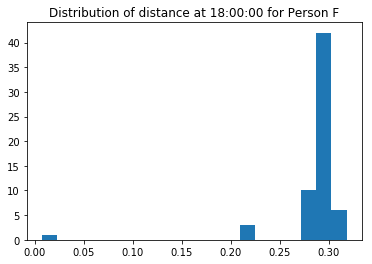

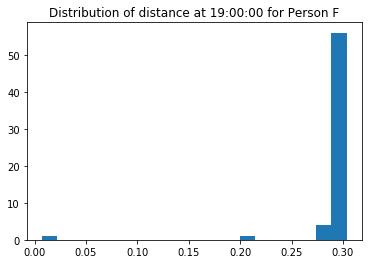

In [28]:
# Plot our features within our training data

person1_features = []
person2_features = []

for X_point, y_point in zip(X_train, y_train):
    if y_point == person1:
        person1_features.append(X_point)
    else:
        person2_features.append(X_point)
        
def plot_features(person, person_features):
    for i, time in enumerate(times_to_measure):
        features = [point[i] for point in person_features]
        plt.hist(features, bins=20)
        plt.title('Distribution of distance at {} for Person {}'.format(time, person))
        plt.show()
    
plot_features(person1, person1_features)
plot_features(person2, person2_features)

In [29]:
# Set up three models to use for our classification problem
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def init_models(X_train, y_train):
    models = [LogisticRegression(),
              RandomForestClassifier(),
              SVC(probability=True)] # Enable the use of predict_proba later
  
    # Fit each model using the training data
    for model in models:
        model.fit(X_train, y_train)
        
    return models

In [30]:
models = init_models(X_train, y_train)

In [31]:
# Print accuracy rate for each classifier on the test data
# (that is, the true positive rate plus the true negative rate)
def name(model):
    return model.__class__.__name__

for model in models:
    print('accuray for {}: {}'.format(name(model), model.score(X_test, y_test)))

accuray for LogisticRegression: 0.6136363636363636
accuray for RandomForestClassifier: 0.9545454545454546
accuray for SVC: 0.9090909090909091


In [32]:
# Function to plot a learning curve.
# Taken from http://scikit-learn.org/dev/_downloads/plot_learning_curve.py

def plot_learning_curve(estimator, plot_title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring=None):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        null for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """    
    from sklearn.learning_curve import learning_curve
    
    plt.figure()
    plt.title(plot_title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Cost = 1 - Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv, n_jobs=n_jobs,
                                                            train_sizes=train_sizes,
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, 1 - train_scores_mean + train_scores_std,
                     1 - train_scores_mean - train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, 1 - test_scores_mean + test_scores_std,
                     1 - test_scores_mean - test_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, 1 - train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, 1 - test_scores_mean, 'o-', color="r",
             label="Test score")

    plt.legend(loc="best")
    plt.show()

D:\Anaconda\envs\aind\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda\envs\aind\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


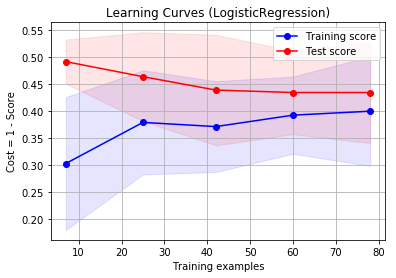

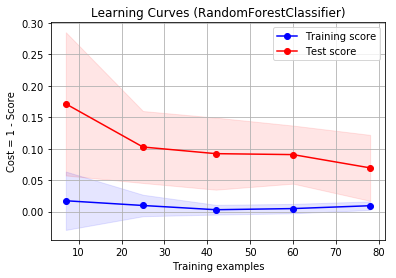

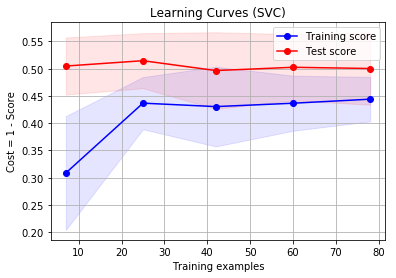

In [33]:
# Plot learning curve - requires bleeding-edge sklearn
import sklearn
from sklearn import cross_validation
for model in models:
    cv = cross_validation.ShuffleSplit(len(X_train), n_iter=25, test_size=0.4)
    plot_title = 'Learning Curves ({})'.format(name(model))
    plot_learning_curve(model, plot_title, X_train, y_train, cv=cv)

In [34]:
# Print accuracy rate for each classifier on the test data
# (that is, the true positive rate plus the true negative rate)
def name(model):
    return model.__class__.__name__

for model in models:
    print('accuray for {}: {}'.format(name(model), model.score(X_test, y_test)))

accuray for LogisticRegression: 0.6136363636363636
accuray for RandomForestClassifier: 0.9545454545454546
accuray for SVC: 0.9090909090909091


In [35]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(model, X_test, y_test, pos_label=True):
    y_pred = model.predict(X_test)
       
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    
    for (pred, true) in zip(y_pred, y_test):
        # Predicted positive and truly positive
        if pred == pos_label and true == pos_label:
            true_positive += 1
        # Predicited positive but truly negative
        elif pred == pos_label:
            false_positive += 1
        # Predicted negative but truly positive
        elif true == pos_label:
            false_negative += 1
        # Predicted negative and truly negative
        else:
            true_negative += 1  
            
    row_fmt = '{:20s} | {:20s} | {:20s}'
    print(row_fmt.format('', 'Condition positive', 'Condition negative'))
    print(row_fmt.format('Test positive', str(true_positive), str(false_positive)))
    print(row_fmt.format('Test negative', str(false_negative), str(true_negative)))

In [36]:
for model in models:
    print('*********** {} ***********\n'.format(name(model)))
    print_confusion_matrix(model, X_test, y_test, pos_label=model.classes_[0])
    print('')

*********** LogisticRegression ***********

                     | Condition positive   | Condition negative  
Test positive        | 53                   | 33                  
Test negative        | 1                    | 1                   

*********** RandomForestClassifier ***********

                     | Condition positive   | Condition negative  
Test positive        | 54                   | 4                   
Test negative        | 0                    | 30                  

*********** SVC ***********

                     | Condition positive   | Condition negative  
Test positive        | 50                   | 4                   
Test negative        | 4                    | 30                  



In [38]:
for model in models:
    y_pred = model.predict(X_test)
    y_true = y_test
    print('*********** {} ***********\n'.format(name(model)))
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

*********** LogisticRegression ***********

[[53  1]
 [33  1]]
*********** RandomForestClassifier ***********

[[54  0]
 [ 4 30]]
*********** SVC ***********

[[50  4]
 [ 4 30]]


In [39]:
# Classify person1 versus all other people rather than just person1 vs person2
# ova stands for one vs. all
ova_person = "G"
events_subset = events[events['driver_id'].apply(lambda p: p in ['A', 'C', 'G', 'F'])]
X_ova, y_intermediate = calculate_points(events_subset)
y_ova = [label == ova_person for label in y_intermediate]
X_train_ova, y_train_ova, X_test_ova, y_test_ova = split_train_test(X_ova, y_ova, train_percent=0.7)

D:\Anaconda\envs\aind\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [40]:
y_intermediate[220:230]

['F', 'F', 'F', 'F', 'F', 'F', 'G', 'G', 'G', 'G']

In [41]:
y_ova[220:230]

[False, False, False, False, False, False, True, True, True, True]

In [42]:
from collections import Counter

print(Counter(y_train_ova).most_common())
print(Counter(y_test_ova).most_common())

[(False, 158), (True, 72)]
[(False, 68), (True, 31)]


In [43]:
ova_models = init_models(X_train_ova, y_train_ova)

In [44]:
for model in ova_models:
    print('accuray for {}: {}'.format(name(model), model.score(X_test_ova, y_test_ova)))

accuray for LogisticRegression: 0.9090909090909091
accuray for RandomForestClassifier: 0.9292929292929293
accuray for SVC: 0.9090909090909091


In [45]:
for model in ova_models:
    print('*********** {} ***********\n'.format(name(model)))
    print_confusion_matrix(model, X_test_ova, y_test_ova)
    print('')

*********** LogisticRegression ***********

                     | Condition positive   | Condition negative  
Test positive        | 27                   | 5                   
Test negative        | 4                    | 63                  

*********** RandomForestClassifier ***********

                     | Condition positive   | Condition negative  
Test positive        | 29                   | 5                   
Test negative        | 2                    | 63                  

*********** SVC ***********

                     | Condition positive   | Condition negative  
Test positive        | 27                   | 5                   
Test negative        | 4                    | 63                  



Area under ROC for LogisticRegression: 0.819
Area under ROC for RandomForestClassifier: 0.991
Area under ROC for SVC: 0.914


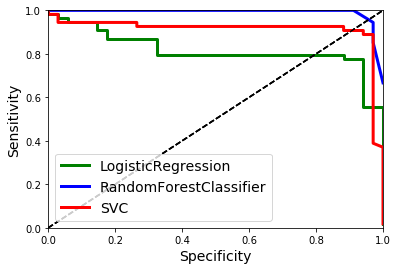

In [46]:
# Plot ROC curve and print the area under the ROC curve
# on the test data for each model

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, color, X_test, y_test):
    probas = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test,
                                     probas[:, 0],
                                     pos_label=model.classes_[0])
    roc_auc = auc(fpr, tpr)
    print('Area under ROC for {}: {:.3f}'.format(name(model), roc_auc))
    
    # Plot ROC curve
    # plot(fpr, tpr, color=color, label='{} 
    # ROC curve (area = {:.2f})'.format(name(model), roc_auc), linewidth=3)
    spec = [ 1- x for x in fpr]
    plt.plot(spec, tpr, color=color, label=name(model), linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.legend(loc=0, prop={'size': 14})

plt.clf()
colors = ["green", "blue", "red"]

for model, color in zip(models, colors):
    plot_roc_curve(model, color, X_test, y_test)
plt.show()

In [47]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(model, color, X_test, y_test):
    probas = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test,
                                                           probas[:, 1])
    area = auc(recall, precision)
    print('Area under curve for {}: {:.3f}'.format(name(model), area))
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, label=name(model), linewidth=3)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.legend(loc=0, prop={'size': 14})

Area under curve for LogisticRegression: 0.934
Area under curve for RandomForestClassifier: 0.989
Area under curve for SVC: 0.925


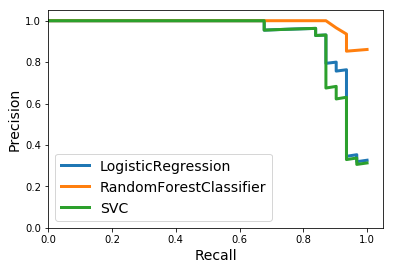

In [48]:
for model, color in zip(ova_models, colors):
    plot_precision_recall_curve(model, color, X_test_ova, y_test_ova)
plt.show()

In [49]:
from sklearn.metrics import classification_report

for model in ova_models:
    print('*********** {} ***********'.format(name(model)))
    print(classification_report(y_test_ova, model.predict(X_test_ova)))
    print('')

*********** LogisticRegression ***********
             precision    recall  f1-score   support

      False       0.94      0.93      0.93        68
       True       0.84      0.87      0.86        31

avg / total       0.91      0.91      0.91        99


*********** RandomForestClassifier ***********
             precision    recall  f1-score   support

      False       0.97      0.93      0.95        68
       True       0.85      0.94      0.89        31

avg / total       0.93      0.93      0.93        99


*********** SVC ***********
             precision    recall  f1-score   support

      False       0.94      0.93      0.93        68
       True       0.84      0.87      0.86        31

avg / total       0.91      0.91      0.91        99




In [50]:
for model in ova_models:
    print('{}: {}'.format(name(model), Counter(model.predict(X_test_ova)).most_common()))
    
print('truth: {}'.format(Counter(y_test_ova).most_common()))

LogisticRegression: [(False, 67), (True, 32)]
RandomForestClassifier: [(False, 65), (True, 34)]
SVC: [(False, 67), (True, 32)]
truth: [(False, 68), (True, 31)]


In [51]:
from sklearn.metrics import fbeta_score

for model in ova_models:
    y_pred = model.predict(X_test_ova)
    
    print('*********** {} ***********'.format(name(model)))
    print('F1 score: {}'.format(fbeta_score(y_test_ova, y_pred, 1)))
    print('F2 score: {}'.format(fbeta_score(y_test_ova, y_pred, 2)))
    print('F0.5 score: {}'.format(fbeta_score(y_test_ova, y_pred, 0.5)))
    print('')

*********** LogisticRegression ***********
F1 score: 0.8571428571428571
F2 score: 0.8653846153846153
F0.5 score: 0.8490566037735848

*********** RandomForestClassifier ***********
F1 score: 0.8923076923076922
F2 score: 0.9177215189873418
F0.5 score: 0.8682634730538922

*********** SVC ***********
F1 score: 0.8571428571428571
F2 score: 0.8653846153846153
F0.5 score: 0.8490566037735848

